In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde
import timeit
from sklearn.linear_model import LogisticRegression
import random
from sklearn.model_selection import train_test_split
import multiprocessing
from dask import compute, delayed
import dask.multiprocessing

### 1.a

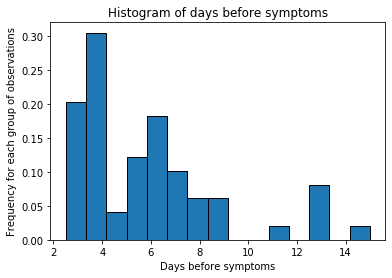

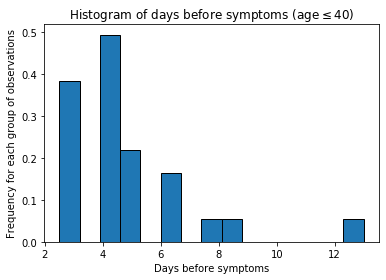

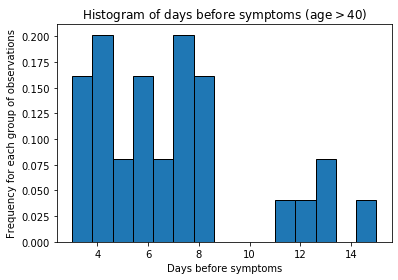

In [21]:
covid_df = pd.read_csv('data/COVIDincubation.txt')
symp_days_ttl = covid_df['symp_days'].values
fig, ax = plt.subplots()
n_total, bin_cuts_total, patches_total = ax.hist(symp_days_ttl, density=True, bins=15, edgecolor='black')
plt.xlabel('Days before symptoms')
plt.ylabel('Frequency for each group of observations')
plt.title('Histogram of days before symptoms')
plt.show()
symp_days_young = covid_df['symp_days'][covid_df['age'] <= 40].values
fig, ax = plt.subplots()
n_young, bin_cuts_young, patches_youngl = ax.hist(symp_days_young, density=True, bins=15, edgecolor='black')
plt.xlabel('Days before symptoms')
plt.ylabel('Frequency for each group of observations')
plt.title('Histogram of days before symptoms (age$\leq$40)')
plt.show()
symp_days_old = covid_df['symp_days'][covid_df['age'] > 40].values
fig, ax = plt.subplots()
n_old, bin_cuts_old, patches_old = ax.hist(symp_days_old, density=True, bins=15, edgecolor='black')
plt.xlabel('Days before symptoms')
plt.ylabel('Frequency for each group of observations')
plt.title('Histogram of days before symptoms (age$>$40)')
plt.show()

### 1.b

In [25]:
N_ttl = symp_days_ttl.size
bandwidths = 10 ** np.linspace(-1, 1, 500)
grid_ttl = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
grid_ttl.fit(symp_days_ttl.reshape((N_ttl, 1)))
bandwidth_ttl_opt = grid_ttl.best_params_['bandwidth']
print("Optimal bandwidths is {}.".format(bandwidth_ttl_opt))
kde_ttl = KernelDensity(bandwidth=bandwidth_ttl_opt, kernel='gaussian')
kde_ttl.fit(symp_days_ttl.reshape((N_ttl, 1)))

Optimal bandwidths is 0.8910453324821516.


KernelDensity(algorithm='auto', atol=0, bandwidth=0.8910453324821516,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

In [26]:
N_old = symp_days_old.size
bandwidths = 10 ** np.linspace(-1, 1, 500)
grid_old = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
grid_old.fit(symp_days_old.reshape((N_old, 1)))
bandwidth_ttl_opt = grid_old.best_params_['bandwidth']
print("Optimal bandwidths is {}.".format(bandwidth_ttl_opt))
kde_old = KernelDensity(bandwidth=bandwidth_ttl_opt, kernel='gaussian')
kde_old.fit(symp_days_old.reshape((N_old, 1)))

Optimal bandwidths is 1.1861737164524786.


KernelDensity(algorithm='auto', atol=0, bandwidth=1.1861737164524786,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

In [27]:
N_young = symp_days_young.size
bandwidths = 10 ** np.linspace(-1, 1, 500)
grid_young = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
grid_young.fit(symp_days_young.reshape((N_young, 1)))
bandwidth_ttl_opt = grid_young.best_params_['bandwidth']
print("Optimal bandwidths is {}.".format(bandwidth_ttl_opt))
kde_young = KernelDensity(bandwidth=bandwidth_ttl_opt, kernel='gaussian')
kde_young.fit(symp_days_young.reshape((N_young, 1)))

Optimal bandwidths is 1.6233824316122782.


KernelDensity(algorithm='auto', atol=0, bandwidth=1.6233824316122782,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

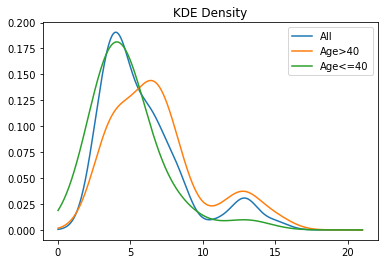

In [54]:
x_pts = np.linspace(0.01, 21, 1000).reshape((1000, 1))
lg_ttl = kde_ttl.score_samples(x_pts).reshape((1000, 1))
plt.plot(x_pts, np.exp(lg_ttl),label=r'All')
plt.title('KDE Density')
lg_old = kde_old.score_samples(x_pts).reshape((1000, 1))
plt.plot(x_pts, np.exp(lg_old), label=r'Age>40')
lg_old = kde_young.score_samples(x_pts).reshape((1000, 1))
plt.plot(x_pts, np.exp(lg_old), label=r'Age<=40')
plt.legend()
plt.show()

### 1.c
The KDE distribution indicates that young individuals with age under 40 has a shorter incubation periods than old individuals. Old individuals have more variance of incubation days than young individuals. 
### 2.a

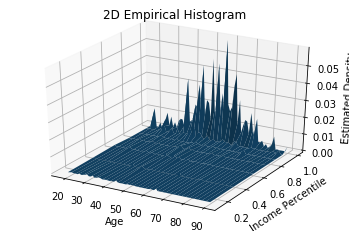

In [53]:
BQ_data = np.loadtxt('data/BQ_probmat.txt', delimiter=',')
age_vec = np.arange(18, 91)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQ_data.reshape((73, 7)))
ax.set_xlabel('Age')
ax.set_ylabel('Income Percentile')
ax.set_zlabel('Estimated Density')
ax.set_title('2D Empirical Histogram')
plt.show()

### 2.b

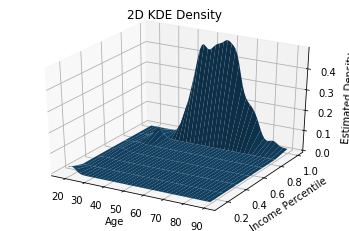

In [52]:
bq = pd.read_csv('data/BQ_ind_data.txt')
bq_mat = bq.values
kde = gaussian_kde(bq_mat.T, bw_method=0.2)
age_array = bq['age']
income_array = bq['income_pctl']
age_min, age_max = age_array.min(), age_array.max()
income_min, income_max = income_array.min(), income_array.max()
age_0, income_0 = np.mgrid[age_min:age_max:73j, income_min:income_max:7j]
positions = np.vstack([age_0.ravel(), income_0.ravel()])
z = np.reshape(kde(positions), age_0.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_0, income_0, z)
ax.set_xlabel('Age')
ax.set_ylabel('Income Percentile')
ax.set_zlabel('Estimated Density')
ax.set_title('2D KDE Density')
plt.show()

In [50]:
print(f'The estimated density for bequest recipient is {z[61 - 18 + 1][5]}')

The estimated density for bequest recipient is 3.747806715061962e-09


By balancing both overfitting and underfitting problems, I choose $\lambda=0.2$, and from the plot, the line fits very well. 